In [ ]:
#  Copyright 2023 Google LLC
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

# Select

The `SELECT` operation, defined by $$ SELECT \left( | i \rangle \otimes | \psi \rangle \right) = |i \rangle \otimes U_i | \psi \rangle $$ is a fundamental primitive in quantum computing. In recent years techniques such as Quantum Singular Value Transformations (QSVT) have brought about a unifying way to construct virtually all known quantum algorithms. Qualtran has a few different techniques for implementing these oracles; this article aims to explain how the basic construction underlying a few of the implementations, known as Unary Iteration, is done. Towards the end, variants such as SELECT-SWAP or QROAM, as well as pointers to specific implementations for physical systems such as chemical systems or Hubbard Models are mentioned. 

## Unary Iteration

Throughout the following discussion we will use the universal gate set of Clifford + T gates, with the goal of minimizing the number of T gates (and therefore Toffoli gates). We also assume that the user has a control register `ctrl` that contains the state to be "selected on" and a system register `sys` that the target unitaries are applied to. We will be very pedagogical and start off with a two qubit `ctrl` register (a 1 qubit `ctrl` is just a controlled version of your bloq), show how to add in additional register, and lastly explain how to move to an arbitrary `ctrl` register using segment trees. Throughout we will demonstrate how to build these bloqs from scratch using Qualtran, so lets import the necessary code now.

In [5]:
from qualtran import BloqBuilder, QUInt, QAny, QBit, Bloq, Signature, CompositeBloq, Soquet
from qualtran.bloqs.basic_gates.rotation import CZPowGate
from qualtran.bloqs.basic_gates.cnot import CNOT
from qualtran.bloqs.mcmt.and_bloq import And
from qualtran.bloqs.basic_gates.toffoli import Toffoli
from qualtran.bloqs.basic_gates.x_basis import XGate
from qualtran.drawing.musical_score import draw_musical_score, get_musical_score_data
from qualtran.drawing import get_musical_score_data, draw_musical_score
import attrs

def int_to_bool_list(num, bitsize):
    x = [bool(num & (1<<n)) for n in range(bitsize)]
    x.reverse()
    return x

As a warmup we will first demonstrate how to do unary iteration with only 2 `ctrl` qubits, meaning we have possibly four nontrivial unitaries $U_0, \ldots, U_3$ that we would like to perform on `sys` based on the state of `ctrl`. Given that we only have access to single qubit controlled unitaries, we will have to iterate through through these unitaries and determine whether or not the `ctrl` register is in the proper state in a single ancilla qubit, which we call `anc`. We can do this pretty straightforwardly using just Toffoli and X gates. The first half is to flip the `ctrl` qubits (0 -> 1 and 1 -> 0) using X, store the Toffoli of these two into `anc` so that `anc = ~ctrl[0] * ~ctrl[1]`, meaning `anc = 1` if and only if both `ctrl` qubits start out in the 0 state. After this we do our controlled $U_0$, which we will use a controlled Z rotation with the index as the rotation angle for demonstration purposes, and then uncompute. The Qualtran code for this is

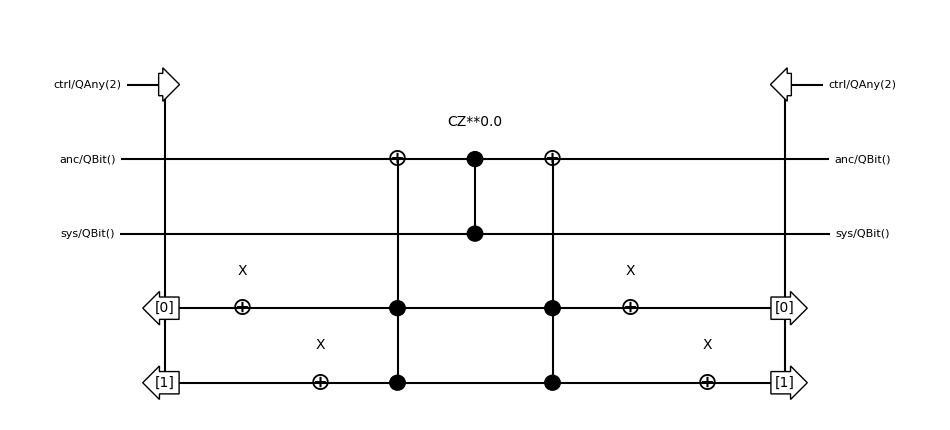

In [3]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now that we have the 0 state taken care of, we can repeat this process for the remaining states 1, 2, and 3. The insight is that the X patterns dictate which state is "selected" on.

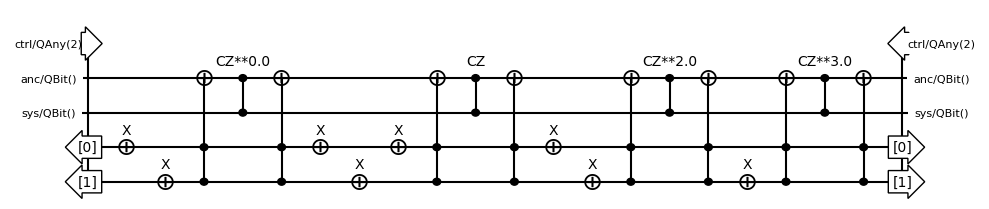

In [4]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

# SELECT on 0 = 00
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 1 = 01
ctrls[0] = bb.add(XGate(), q=ctrls[0])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=1.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])

# SELECT on 2 = 10
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=2.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 3 = 11
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=3.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now the above cirquit is correct (TODO: Should we add in testing?), but there is a lot of redundancy. For example, the two X gates done back to back on the `ctrls[0]` register can be cancelled. The second gate saving we could do is based on the identity that an X gate between two Toffoli's can be replaced with the same X gate and a CNot on the other control
$$
Toffoli \cdot I \otimes X \otimes I \cdot Toffoli = CNOT(1, 3) \cdot I \otimes X \otimes I.
$$
Implementing these reductions gives the final unary iteration bloq for 0,...,3 as

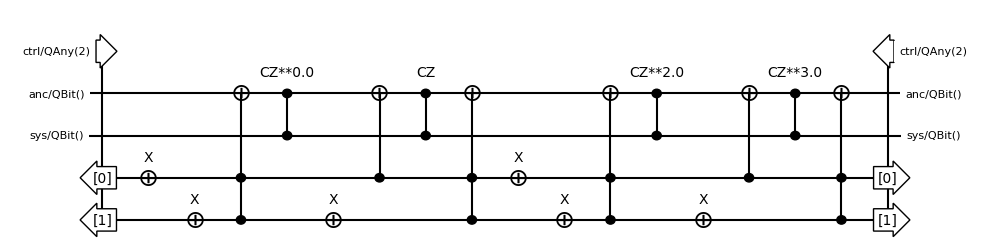

In [5]:
bb = BloqBuilder()
ctrl = bb.add_register_from_dtype("ctrl", QAny(2))
ctrls = bb.split(ctrl)
anc = bb.add_register_from_dtype("anc", QBit())
sys = bb.add_register_from_dtype("sys", QBit())

# SELECT on 0 = 00
ctrls[0] = bb.add(XGate(), q=ctrls[0])
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=0.0), q=[anc, sys])

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 1 = 01

ctrls[0], anc = bb.add(CNOT(), ctrl=ctrls[0], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=1.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrls[0] = bb.add(XGate(), q=ctrls[0])

# SELECT on 2 = 10
ctrls[1] = bb.add(XGate(), q=ctrls[1])

[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=2.0), q=[anc, sys])

ctrls[1] = bb.add(XGate(), q=ctrls[1])

# SELECT on 3 = 11
ctrls[0], anc = bb.add(CNOT(), ctrl=ctrls[0], target=anc)
[anc, sys] = bb.add(CZPowGate(exponent=3.0), q=[anc, sys])
[ctrls[0], ctrls[1]], anc = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=anc)

ctrl = bb.join(ctrls)
cbloq = bb.finalize(ctrl=ctrl, anc=anc, sys=sys)

msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

Now from these simplifications it is pretty clear that there are two groups of operations going on, the $U_0$ and $U_1$ half and the $U_2, U_3$ half. Since there are no more simplifications to make, we can now proceed to analyze what exactly the circuit is doing at each step, with the intent to generalize to larger control registers. The way we will go about this is by tracking the state of the ancilla qubit right before each CZ. We will do so using boolean algebra, if $x$ and $y$ are variables then $\bar{x}$ denotes the logical NOT of $x$, $x \oplus y$ the XOR operation, and $x \otimes y$ the AND operation. We also use $c_0$ and $c_1$ to denote the state of the `ctrl` qubits 0 and 1 respectively.

Before CZ**0.0, the state of the ancilla is just the output of the Toffoli, which is 
$$|\bar{c_0} \otimes \bar{c_1} \rangle.$$ 

Now to get to the state before `CZ**1.0` we just have to do a CNOT with the control in the state $\bar{c_0}$. This results in
$$ |\bar{c_0} \otimes \bar{c_1} \oplus \bar{c_0} \rangle = |\bar{c_0} \otimes (\bar{c_1} \oplus 1) \rangle = |\bar{c_0} \otimes c_1 \rangle.$$ 
This is clearly only 1 if the control register is in 01 as we wanted.

To get to the next `CZ` we have to perform two Toffoli gates. Instead of doing one after the other we can add into the ancilla the net result of both of them. As one Toffoli has the effect of adding in the logical multiplication of the two controls, the net effect of the two Toffoli's between `CZ**1.0` and `CZ**2.0` is to add in $\bar{c_0} \otimes c_1 \oplus c_0 \otimes \bar{c_1}$. Adding this into the ancilla state from the previous expression gives us
$$ |\bar{c_0} \otimes c_1 \oplus \bar{c_0} \otimes c_1 \oplus c_0 \otimes \bar{c_1} \rangle = |c_0 \otimes \bar{c_1} \rangle $$

By now it should be clear what the next state will be, the CNOT added into this last state gives us
$$ |c_0 \otimes \bar{c_1} \oplus c_0 \rangle = |c_0 \otimes (\bar{c_1} \oplus 1) \rangle = |c_0 \otimes c_1\rangle, $$
as it should. 

## Beyond 2 Control Qubits with Segment Trees

Now that we know the ins and outs of how the 2 qubit Unary Iteration works it is clear that if we wanted to do an arbitrary controlled qubit we could just extend this process: Compute the $n$-qubit AND of the `ctrl` qubits, using `n-1` ancillas, uncompute, and then flip the `ctrl` qubits to change which qubit we are selecting on. After this circuit is laid out, we can go back and perform cancellations to reduce the number of gates significantly. Although this would work, adding gates just to cancel them later is rather inefficient and it would be better if we could introduce structure which would let us get the correct gates from the start. The abstraction we will use which lets us do this is called a Segment Tree, or an interval tree, which we will develop a small example of now.

A [Segment Tree](https://en.wikipedia.org/wiki/Segment_tree) is a way of organizing partial information about a collection of segments of the 1D real line, so a single position axis. The partial information allows us to query which intervals in the set contain a given query point on the line. For us, our intervals will all be disjoint, unit-length intervals but the partial information used in the Segment Tree will allow us to perform iterated select queries efficiently. 

In [6]:
class SegmentTree():
    ctrl_bitsize: int
    def __init__(self, ctrl_bitsize: int):
        """A segment tree with unit intervals that can iterate through all possible configurations of ctrl bits.
        """
        # We need ctrl_bitsize - 1 ancillas, initialize them to 0
        self.ancilla_bits = [False for ix in range(ctrl_bitsize - 1)]
        self.ctrl_bitsize = int(ctrl_bitsize)
    
    def query(self, ctrl, q):
        assert len(q) == self.ctrl_bitsize
        self.ancilla_bits[0] = (ctrl[0] == q[0]) and (ctrl[1] == q[1])
        for ix in range(1, len(self.ancilla_bits)):
            self.ancilla_bits[ix] = self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])
        print("ancillas:", self.ancilla_bits)
        return self.ancilla_bits[-1]

st = SegmentTree(3)
st.query([True, False, True], [True, False, True])
st.query([True, False, True], [True, False, False])

ancillas: [True, True]
ancillas: [True, False]


False

Currently this recomputes all of the ancillas with every single query, which is bad if we only change the lower order bits. Lets look at a small example before adding in support for storing prior queries. Here we can see that the first half of the ancillas, corresponding to the higher order bits, do not change from changing the query to 

In [7]:
st = SegmentTree(5)
st.query([True, True, False, False, False], [True, True, False, True, False])
st.query([True, True, False, False, False], [True, True, False, False, False])

ancillas: [True, True, False, False]
ancillas: [True, True, True, True]


True

In [8]:
class SegmentTree():
    ctrl_bitsize: int
    def __init__(self, ctrl_bitsize: int):
        """A segment tree that queries a `ctrl` register with `query`s to apply an operation `op[q]` on a system register.
        """
        # We need ctrl_bitsize - 1 ancillas, initialize them to 0
        self.ancilla_bits = [False for ix in range(ctrl_bitsize - 1)]
        self.ctrl_bitsize = int(ctrl_bitsize)
        self.prev_query = None
    
    def query(self, ctrl, q):
        assert len(q) == self.ctrl_bitsize
        if self.prev_query is None:
            self.ancilla_bits[0] = (ctrl[0] == q[0]) and (ctrl[1] == q[1])
            for ix in range(1, len(self.ancilla_bits)):
                self.ancilla_bits[ix] = self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])
            self.prev_query = q
        else:
            # find first index where they differ
            first_diff_ix = None
            for ix in range(len(q)):
                if q[ix] != self.prev_query[ix]:
                    first_diff_ix = ix
                    break
            if first_diff_ix is None:
                # the two queries are equal, we can just use the previously computed ancillas
                return self.ancilla_bits[-1]
            if first_diff_ix <= 1:
                # we can't reause anything.
                self.prev_query = None
                return self.query(ctrl, q)
            for ix in range(first_diff_ix - 1, len(self.ancilla_bits)):
                self.ancilla_bits[ix] = self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])
                print("computing new values for ix = ", ix, ", ancilla_bits[ix] = ", self.ancilla_bits[ix])
            self.prev_query = q
        print("ancillas:", self.ancilla_bits)
        return self.ancilla_bits[-1]

So now we see that modifying a query only a little bit only recomputes a few ancillas:

In [9]:
st = SegmentTree(5)
st.query([True, True, False, False, False], [True, True, False, True, False])
st.query([True, True, False, False, False], [True, True, False, False, False])
st.query([True, True, False, False, False], [True, True, False, False, True])

ancillas: [True, True, False, False]
computing new values for ix =  2 , ancilla_bits[ix] =  True
computing new values for ix =  3 , ancilla_bits[ix] =  True
ancillas: [True, True, True, True]
computing new values for ix =  3 , ancilla_bits[ix] =  False
ancillas: [True, True, True, False]


False

We see in the above example that changing the lowest order bit in the query requires us to only change the last ancilla bit, which makes intuitive sense. 
TODO: Should write something about how this actually encodes a Segment tree?

Now that we have a data structure that can query the state of `ctrl` given `q` our next goal is to extend it to act on a quantum `ctrl` register and utilize ancilla *qubits*, not bits. The key point to remember is that the query is still classical. Now the first thing we have to do to update our boolean logic to be reversible, as we currently just set our classical `ancilla_bits` to whatever we need them to be. One thing to keep in mind is that the uncomputation works in reverse, if we have ancillas $[c_0 \land c_1, c_0 \land c_1 \land c_2, c_0 \land c_1 \land c_2 \land c_3]$ we would uncompute them as $\to [c_0 \land c_1, c_0 \land c_1 \land c_2, 0] \to [c_0 \land c_1, 0, 0]$. One of the key insights is that when we uncompute and then recompute the ancillas, the most significant ancilla can simply be updated instead of uncomputed. This is the $Toffoli(a,b,c) \cdot I \otimes X \otimes I \cdot Toffoli(a,b,c) = CNOT(a, c) \cdot I \otimes X \otimes I$ gate reduction we implemented. 

In [6]:
class SegmentTree():
    ctrl_bitsize: int
    def __init__(self, ctrl_bitsize: int):
        """A segment tree that queries a `ctrl` register with `query`s to apply an operation `op[q]` on a system register.
        """
        # We need ctrl_bitsize - 1 ancillas, initialize them to 0
        self.ancilla_bits = [False for ix in range(ctrl_bitsize - 1)]
        self.ctrl_bitsize = int(ctrl_bitsize)
        self.prev_query = None
    
    def query(self, ctrl, q):
        assert len(q) == self.ctrl_bitsize
        if self.prev_query is None:
            self.ancilla_bits[0] = (ctrl[0] == q[0]) and (ctrl[1] == q[1])
            for ix in range(1, len(self.ancilla_bits)):
                self.ancilla_bits[ix] = self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])
            self.prev_query = q
            return
        else:
            # find first index where they differ
            first_diff_ix = None
            for ix in range(len(q)):
                if q[ix] != self.prev_query[ix]:
                    first_diff_ix = ix
                    break
            if first_diff_ix is None:
                # the two queries are equal, we can just use the previously computed ancillas
                return self.ancilla_bits[-1]
            if first_diff_ix <= 1:
                # we can't reause anything.
                self.prev_query = None
                return self.query(ctrl, q)
            # Uncompute the ancillas we will need
            for ix in range(len(self.ancilla_bits) - 1, first_diff_ix - 1, -1):
                print('uncompute ix = ', ix)
                self.ancilla_bits[ix] = (self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])) ^ (self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1]))
            # Now the "uncompute" for the most significant ancilla is actually an update
            self.ancilla_bits[first_diff_ix - 1] = self.ancilla_bits[first_diff_ix - 1] ^ self.ancilla_bits[first_diff_ix - 2]
            print("ancillas after uncomputation: ", self.ancilla_bits)
            for ix in range(first_diff_ix - 1, len(self.ancilla_bits)):
                self.ancilla_bits[ix] = self.ancilla_bits[ix - 1] and (ctrl[ix + 1] == q[ix + 1])
                print("computing new values for ix = ", ix, ", ancilla_bits[ix] = ", self.ancilla_bits[ix])
            self.prev_query = q
        print("ancillas before returning:", self.ancilla_bits)
        return self.ancilla_bits[-1]

In [11]:
st = SegmentTree(5)
st.query([True, True, False, False, False], [True, True, False, True, False])
st.query([True, True, False, False, False], [True, True, False, False, False])
st.query([True, True, False, False, False], [True, True, False, False, True])

ancillas before returning: [True, True, False, False]
uncompute ix =  3
ancillas after uncomputation:  [True, True, True, False]
computing new values for ix =  2 , ancilla_bits[ix] =  True
computing new values for ix =  3 , ancilla_bits[ix] =  True
ancillas before returning: [True, True, True, True]
ancillas after uncomputation:  [True, True, True, False]
computing new values for ix =  3 , ancilla_bits[ix] =  False
ancillas before returning: [True, True, True, False]


False

Now that we have all the reversible logic implemented and the iterative queries implemented we can finally move on to using this to build a bloq that acts on **quantum** registers! We now have to be able to query `ctrl` that is a quantum register using ancillas that are also qubits. This will essentially boil down to moving our AND and XOR logic to Toffolis and CNots. A first stab at this is below

In [15]:
from typing import Dict, List
from qualtran import BloqBuilder, Register
from qualtran._infra.composite_bloq import SoquetT
from numpy import ndarray
class UnaryIteration(Bloq):
    ctrl_bitsize: int
    prev_query = None
    sys_bitsize: int
    ops: Dict[int, Bloq]
    ctrl_inversions: List[bool] = None

    def set_ops(self, ops):
        self.ops = ops

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QAny(self.ctrl_bitsize)), Register('anc', QAny(self.ctrl_bitsize - 1)), Register('sys', QAny(self.sys_bitsize))])
    
    def query(self, q, bb, ancs, ctrls) -> CompositeBloq:
        assert len(q) == self.ctrl_bitsize
        if self.ctrl_inversions is None:
            self.ctrl_inversions = [False for _ in range(self.ctrl_bitsize)]
        print('query: ', q, " prev_query: ", self.prev_query)
        if self.prev_query is None:
            for ix in range(len(q)):
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q = ctrls[ix])
            [ctrls[0], ctrls[1]], ancs[0] = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=ancs[0])
            for ix in range(1, len(ancs)):
                [ancs[ix - 1], ctrls[ix + 1]], ancs[ix] = bb.add(Toffoli(), ctrl=[ancs[ix - 1], ctrls[ix + 1]], target=ancs[ix]) 
            for ix in range(len(q)):
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q = ctrls[ix])
            self.prev_query = q
            return
        # now we need to find where the previous and current query differ
        first_diff_ix = None
        for ix in range(len(q)):
            if q[ix] != self.prev_query[ix]:
                first_diff_ix = ix
                break
        if first_diff_ix is None:
            # the two queries are equal, so we don't have to update anything.
            return
        
        for ix in range(len(ancs) - 1, first_diff_ix - 1, -1):
            print("uncompute ix: ", ix)
            if ix == 0:
                if self.prev_query[ix + 1] is False and self.ctrl_inversions[ix + 1] is False:
                    ctrls[ix + 1] = bb.add(XGate(), q=ctrls[ix + 1])
                if self.prev_query[ix] is False and self.ctrl_inversions[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
                [ctrls[0], ctrls[1]], ancs[ix] =  bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=ancs[ix])
                if self.prev_query[ix + 1] is False and self.ctrl_inversions[ix + 1] is False:
                    ctrls[ix + 1] = bb.add(XGate(), q=ctrls[ix + 1])
                if self.prev_query[ix] is False and self.ctrl_inversions[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
            else:
                if self.prev_query[ix + 1] is False and self.ctrl_inversions[ix + 1] is False:
                    ctrls[ix + 1] = bb.add(XGate(), q=ctrls[ix + 1])
                [ctrls[ix + 1], ancs[ix - 1]], ancs[ix] =  bb.add(Toffoli(), ctrl=[ctrls[ix + 1], ancs[ix - 1]], target=ancs[ix])
                if self.prev_query[ix + 1] is False and self.ctrl_inversions[ix + 1] is False:
                    ctrls[ix + 1] = bb.add(XGate(), q=ctrls[ix + 1])
                self.ctrl_inversions[ix + 1] = False
        
        print("first diff ix, ", first_diff_ix)
        if first_diff_ix == 1:
            if self.prev_query[first_diff_ix - 1] is False:
                ctrls[first_diff_ix - 1] = bb.add(XGate(), q=ctrls[first_diff_ix - 1])
            ctrls[first_diff_ix -1 ], ancs[first_diff_ix - 1] = bb.add(CNOT(), ctrl=ctrls[first_diff_ix -1], target=ancs[first_diff_ix - 1])
            if self.prev_query[first_diff_ix - 1] is False:
                ctrls[first_diff_ix - 1] = bb.add(XGate(), q=ctrls[first_diff_ix - 1])
            self.ctrl_inversions[first_diff_ix] = True
        elif first_diff_ix > 1:
            ancs[first_diff_ix - 2], ancs[first_diff_ix - 1] = bb.add(CNOT(), ctrl=ancs[first_diff_ix - 2], target=ancs[first_diff_ix - 1])
            self.ctrl_inversions[first_diff_ix] = True
        for ix in range(first_diff_ix + 1, self.ctrl_bitsize): 
            print("compute ix: ", ix)
            if ix == 1:
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
                [ctrls[0], ctrls[1]], ancs[0] = bb.add(Toffoli(), ctrl=[ctrls[0], ctrls[1]], target=ancs[0])
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
            else:
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
                print("ctrls: ", ctrls)
                print("ancs: ", ancs[ix - 1])
                [ctrls[ix], ancs[ix - 2]], ancs[ix - 1] = bb.add(Toffoli(), ctrl=[ctrls[ix], ancs[ix - 2]], target=ancs[ix-1])
                if q[ix] is False:
                    ctrls[ix] = bb.add(XGate(), q=ctrls[ix])
        self.prev_query = q
        return
    
    def build_composite_bloq(self, bb: BloqBuilder, ctrl: SoquetT, anc: SoquetT, sys: SoquetT) -> Dict[str, 'SoquetT']:
        queries = list(self.ops.keys())
        queries.sort()
        ctrls = bb.split(ctrl)
        ancs = bb.split(anc)
        for q_int in queries:
            q_bools = int_to_bool_list(q_int, self.ctrl_bitsize)
            self.query(q_bools, bb, ancs, ctrls)
            [ancs[-1], sys] = bb.add(self.ops[q_int], q=[ancs[-1], sys])
        ctrl = bb.join(ctrls)
        anc = bb.join(ancs)
        return {'ctrl': ctrl, 'sys': sys, 'anc': anc}

query:  [False, False, False]  prev_query:  None
query:  [False, False, True]  prev_query:  [False, False, False]
first diff ix,  2
query:  [False, True, False]  prev_query:  [False, False, True]
uncompute ix:  1
first diff ix,  1
compute ix:  2
ctrls:  [Soquet(binst=BloqInstance(bloq=XGate(), i=16), reg=Register(name='q', dtype=QBit(), _shape=(), side=<Side.THRU: 3>), idx=())
 Soquet(binst=BloqInstance(bloq=XGate(), i=8), reg=Register(name='q', dtype=QBit(), _shape=(), side=<Side.THRU: 3>), idx=())
 Soquet(binst=BloqInstance(bloq=XGate(), i=17), reg=Register(name='q', dtype=QBit(), _shape=(), side=<Side.THRU: 3>), idx=())]
ancs:  Toffoli<13>.target
query:  [False, True, True]  prev_query:  [False, True, False]
first diff ix,  2
query:  [True, False, False]  prev_query:  [False, True, True]
uncompute ix:  1
uncompute ix:  0
first diff ix,  0
compute ix:  1
compute ix:  2
ctrls:  [Soquet(binst=BloqInstance(bloq=Toffoli(), i=28), reg=Register(name='ctrl', dtype=QBit(), _shape=(2,), side=

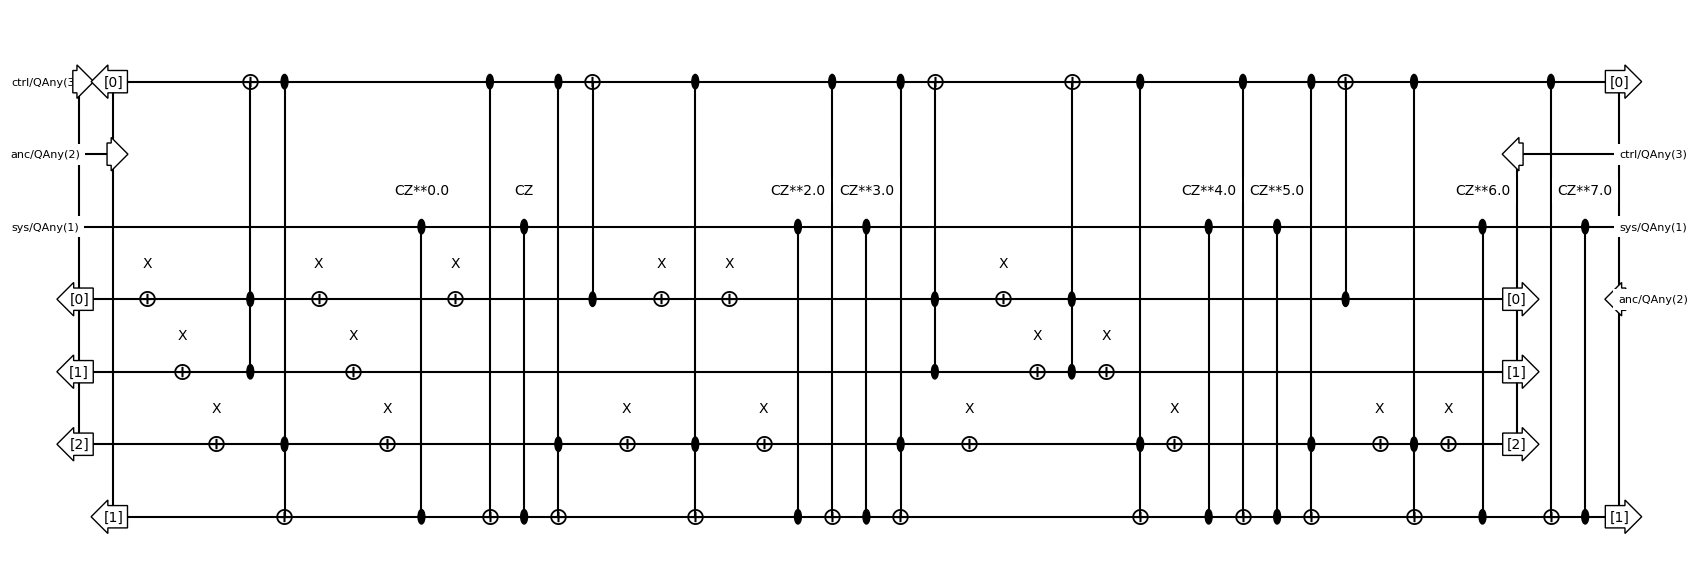

In [16]:
from qualtran.drawing._show_funcs import show_bloq


cbloq = UnaryIteration()
cbloq.ctrl_bitsize = 3
cbloq.sys_bitsize = 1
ops = dict()
for ix in range(8):
    ops[ix] = CZPowGate(exponent=float(ix))
cbloq.set_ops(ops)
msd = get_musical_score_data(cbloq.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(18)
fig.set_figheight(7)


In [ ]:
class RecursiveUnaryIteration(Bloq):
    ctrl_bitsize: int
    state = []
    sys_bitsize: int
    ops: Dict[int, Bloq]
    ctrl_inversions: List[bool] = None

    def set_ops(self, ops):
        self.ops = ops

    @property
    def signature(self) -> Signature:
        return Signature([Register('ctrl', QAny(self.ctrl_bitsize)), Register('anc', QAny(self.ctrl_bitsize - 1)), Register('sys', QAny(self.sys_bitsize))])
    
    def select(self, query: List[bool], bb, ancs, ctrls):
        assert len(self.state) <= len(query)
        first_diff_ix = None
        for ix in range(len(self.state)):
            if query[ix] != self.state[ix]:
                first_diff_ix = ix
                break

        if first_diff_ix is None:
            # The state is a prefix of the query
            if len(self.state) == len(query):
                return
            else:
                # Need to compute
                if len(self.state) == 0:
                    [ctrls[0], ctrls[1]] = bb.add(And(not query[0], not query[1]), ctrl=[ctrls[0], ctrls[1]], target=ancs[0])
                    self.state.append(query[0])
                    self.state.appens(query[1])
                    self.select(query, bb, ancs, ctrls)
                else:
                    [ctrls[first_diff_ix], ancs[first_diff_ix - 2]] = bb.add(And(not query[first_diff_ix], True), ctrl=[ctrls[first_diff_ix], ancs[first_diff_ix - 2]], target=ancs[first_diff_ix - 1])
        else:
            # We still need to uncompute
            if len(self.state) == 2 and first_diff_ix == 1:
                # The base case, we need to completely fix our regs
                pass

        if first_diff_ix < len(self.state) - 1:
            # We have to uncompute the state until it is the last bit
            pass
        elif first_diff_ix == len(self.state) - 1:
            # We can flip using CNOT
            if first_diff_ix == 1:
                pass

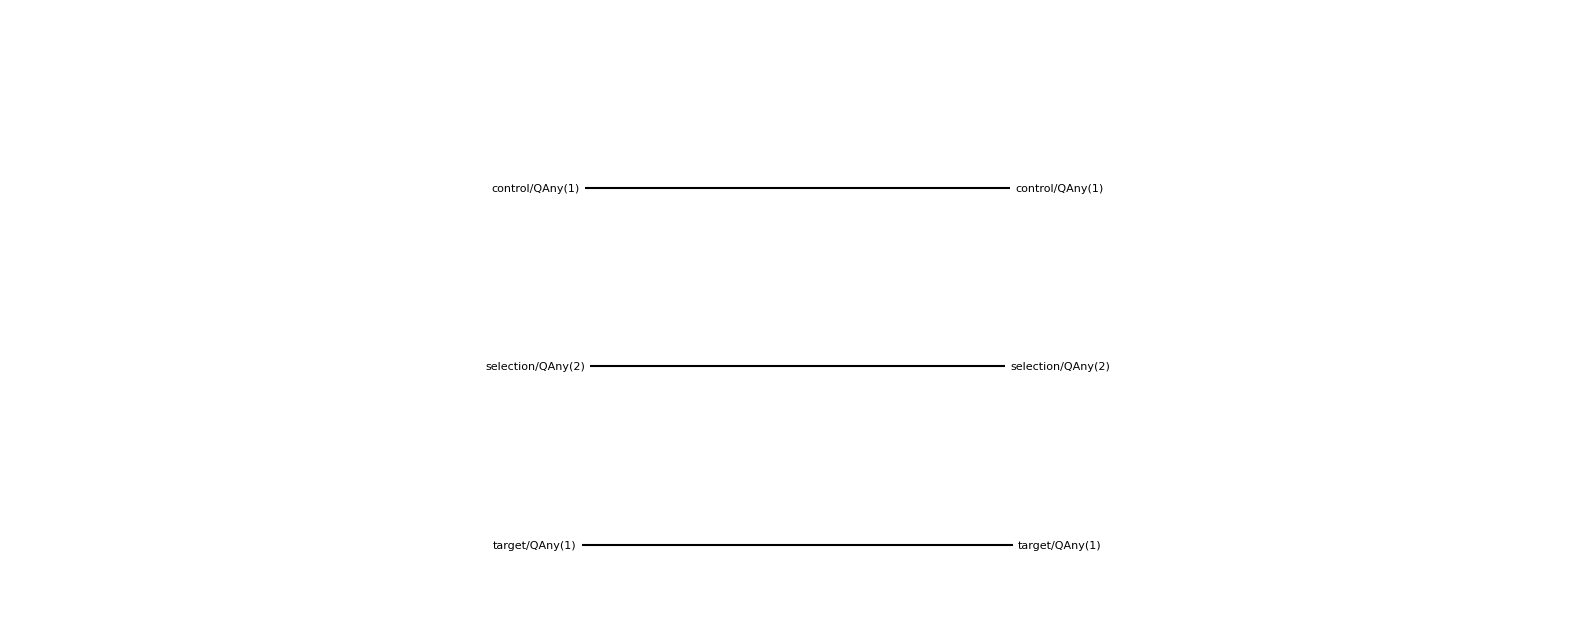

In [24]:
from functools import cached_property
from typing import Sequence, Set, Tuple

import cirq
from qualtran._infra.data_types import BoundedQUInt
from qualtran.bloqs.multiplexers.unary_iteration_bloq import UnaryIterationGate
from qualtran.resource_counting._call_graph import BloqCountT

class UnaryTest(UnaryIterationGate):
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize
    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        return (Register('selection', QAny(self._selection_bitsize)),)

    @cached_property
    def target_registers(self) -> Tuple[Register, ...]:
        return (Register('target', QAny(self._target_bitsize)),)
    
    @cached_property
    def control_registers(self) -> Tuple[Register, ...]:
        return (Register('control', QAny(self._control_bitsize)),)
    
    def nth_operation(  # type: ignore[override]
        self,
        context: cirq.DecompositionContext,
        control: cirq.Qid,
        selection: int,
        target: Sequence[cirq.Qid],
    ) -> cirq.OP_TREE:
        return cirq.CZPowGate(exponent=selection).on(control, selection)
    
    def nth_operation_callgraph(self, **selection_regs_name_to_val) -> Set['BloqCountT']:
        return {(CZPowGate(), 1)}
    
example = UnaryTest(2, 1)
msd = get_musical_score_data(example.decompose_bloq())
fig, ax = draw_musical_score(msd)
fig.set_figwidth(18)
fig.set_figheight(7)

Given an array of potential operations, for example:

    ops = [X(i) for i in range(5)]
    
we would like to select an operation to apply:

    n = 4 --> apply ops[4]
    
If $n$ is a quantum integer, we need to apply the transformation

$$
    |n \rangle |\psi\rangle \rightarrow |n\rangle \, \mathrm{ops}_n \cdot |\psi\rangle
$$

The simplest conceptual way to do this is to use a "total control" quantum circuit where you introduce a multi-controlled operation for each of the `len(ops)` possible `n` values.

In [ ]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np
from typing import *

In [ ]:
import operator
import cirq._compat
import itertools

## Total Control

Here, we'll use Sympy's boolean logic to show how total control works. We perform an `And( ... )` for each possible bit pattern. We use an `Xnor` on each selection bit to toggle whether it's a positive or negative control (filled or open circle in quantum circuit diagrams).

In this example, we indeed consider $X_n$ as our potential operations and toggle bits in the `target` register according to the total control.

In [ ]:
import sympy as S
import sympy.logic.boolalg as slb

def total_control(selection, target):
    """Toggle bits in `target` depending on `selection`."""
    print(f"Selection is {selection}")
    
    for n, trial in enumerate(itertools.product((0, 1), repeat=len(selection))):
        print(f"Step {n}, apply total control: {trial}")
        target[n] ^= slb.And(*[slb.Xnor(s, t) for s, t in zip(selection, trial)])
          
        if target[n] == S.true:
            print(f"  -> At this stage, {n}= and our output bit is set")

        
selection = [0, 0, 0]
target = [False]*8
total_control(selection, target)    
print()
print("Target:")
print(target)

Note that our target register shows we have indeed applied $X_\mathrm{0b010}$. Try changing `selection` to other bit patterns and notice how it changes.

Of course, we don't know what state the selection register will be in. We can use sympy's support for symbolic boolean logic to verify our gadget for all possible selection inputs.

In [ ]:
selection = [S.Symbol(f's{i}') for i in range(3)]
target = [S.false for i in range(2**len(selection)) ]
total_control(selection, target)

print()
print("Target:")
for n, t in enumerate(target):
    print(f'{n}= {t}')
    
tc_target = target.copy()

As expected, the "not pattern" (where `~` is boolean not) matches the binary representations of `n`.

## Unary Iteration with segment trees

A [segment tree](https://en.wikipedia.org/wiki/Segment_tree) is a data structure that allows logrithmic-time querying of intervals. We use a segment tree where each interval is length 1 and comprises all the `n` integers we may select.

It is defined recursively by dividing the input interval into two half-size intervals until the left limit meets the right limit.

In [ ]:
def segtree(ctrl, selection, target, depth, left, right):
    """Toggle bits in `target` depending on `selection` using a recursive segment tree."""
    print(f'depth={depth} left={left} right={right}', end=' ')
    
    if left == (right - 1):
        # Leaf of the recusion.
        print(f'n={n} ctrl={ctrl}')
        target[left] ^= ctrl
        return 
    print()
    
    assert depth < len(selection)
    mid = (left + right) >> 1
    
    # Recurse left interval
    new_ctrl = slb.And(ctrl, slb.Not(selection[depth]))
    segtree(ctrl=new_ctrl, selection=selection, target=target, depth=depth+1, left=left, right=mid)
    
    # Recurse right interval
    new_ctrl = slb.And(ctrl, selection[depth])
    segtree(ctrl=new_ctrl, selection=selection, target=target, depth=depth+1, left=mid, right=right)
    
    # Quantum note:
    # instead of throwing away the first value of `new_ctrl` and re-anding
    # with selection, we can just invert the first one (but only if `ctrl` is active)
    # new_ctrl ^= ctrl

In [ ]:
selection = [S.Symbol(f's{i}') for i in range(3)]
target = [S.false for i in range(2**len(selection)) ]
segtree(S.true, selection, target, 0, 0, 2**len(selection))

print()
print("Target:")
for n, t in enumerate(target):
    print(f'n={n} {slb.simplify_logic(t)}')

In [ ]:
print(f"{'n':3s} | {'segtree':18s} | {'total control':18s} | same?")
for n, (t1, t2) in enumerate(zip(target, tc_target)):
    t1 = slb.simplify_logic(t1)
    print(f'{n:3d} | {str(t1):18s} | {str(t2):18s} | {str(t1==t2)}')

## Quantum Circuit

We can translate the boolean logic to reversible, quantum logic. It is instructive to start from the suboptimal total control quantum circuit for comparison purposes. We can build this as in the sympy boolean-logic case by adding controlled X operations to the target signature, with the controls on the selection signature toggled on or off according to the binary representation of the selection index.

Let us first build a GateWithRegisters object to implement the circuit

In [ ]:
import cirq
from functools import cached_property
from qualtran import Signature, GateWithRegisters, QUInt

class TotallyControlledNot(GateWithRegisters):
    
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize

    @cached_property
    def signature(self) -> Signature:
        return Signature(
            [
                *Signature.build(control=self._control_bitsize),
                *Signature.build(selection=self._selection_bitsize),
                *Signature.build(target=self._target_bitsize)
            ]
        )

    def decompose_from_registers(self, **qubit_regs: Sequence[cirq.Qid]) -> cirq.OP_TREE:
        num_controls = self._control_bitsize + self._selection_bitsize
        for target_bit in range(self._target_bitsize):
            bit_pattern = QUInt(self._selection_bitsize).to_bits(target_bit)
            control_values = [1]*self._control_bitsize + list(bit_pattern)
            yield cirq.X.controlled(
                num_controls=num_controls,
                control_values=control_values
                ).on(
                    *qubit_regs["control"], 
                    *qubit_regs["selection"],
                    qubit_regs["target"][-(target_bit+1)])
        

In [ ]:
import qualtran.cirq_interop.testing as cq_testing
tc_not = TotallyControlledNot(3, 5)
tc = cq_testing.GateHelper(tc_not)
cirq.Circuit((cirq.decompose_once(tc.operation)))
SVGCircuit(cirq.Circuit(cirq.decompose_once(tc.operation)))

## Tests for Correctness

We can use a full statevector simulation to compare the desired statevector to the one generated by the unary iteration circuit for each basis state.

In [ ]:
selection_bitsize = 3
target_bitsize = 5
for n in range(target_bitsize):
    # Initial qubit values
    qubit_vals = {q: 0 for q in tc.all_qubits}
    # All controls 'on' to activate circuit
    qubit_vals.update({c: 1 for c in tc.quregs['control']})
    # Set selection according to `n`
    qubit_vals.update(zip(tc.quregs['selection'], QUInt(selection_bitsize).to_bits(n)))

    initial_state = [qubit_vals[x] for x in tc.all_qubits]
    final_state = [qubit_vals[x] for x in tc.all_qubits]
    final_state[-(n+1)] = 1
    cq_testing.assert_circuit_inp_out_cirqsim(
        tc.circuit, tc.all_qubits, initial_state, final_state
    )
    print(f'n={n} checked!')

## Towards a segment tree 

Next let's see how we can reduce the circuit to the observe the tree structure.
First let's recall what we are trying to do with the controlled not. Given a
selection integer (say 3 = 011), we want to toggle the bit in the target
register to on if the qubit 1 and 2 are set to on in the selection register.

In [ ]:
# The selection bits [1-3] are set according to binary representation of the number 3 (011)
initial_state = [1, 0, 1, 1, 0, 0, 0, 0, 0]
final_state = [1, 0, 1, 1, 0, 1, 0, 0, 0]
actual, should_be = cq_testing.get_circuit_inp_out_cirqsim(
        tc.circuit, tc.all_qubits, initial_state, final_state
    )
print("simulated: ", actual)
print("expected : ", should_be)


Now what is important to note is that we can remove many repeated controlled operations by using ancilla qubits to flag what part of the circuit we need to apply, this works because we know the bit pattern of nearby integers is very similar. 

A circuit demonstrating this for our example is given below.

In [ ]:
from qualtran.bloqs.mcmt import And

selection_bitsize = 2
target_bitsize = 4
qubits = cirq.LineQubit(0).range(1 + selection_bitsize * 2 + target_bitsize)
circuit = cirq.Circuit()
circuit.append(
    [
        And(1, 0).on(qubits[0], qubits[1], qubits[2]),
        And(1, 0).on(qubits[2], qubits[3], qubits[4]),
        cirq.CX(qubits[4], qubits[8]),
        cirq.CNOT(qubits[2], qubits[4]),
        cirq.CX(qubits[4], qubits[7]),
        And().adjoint().on(qubits[2], qubits[3], qubits[4]),
        cirq.CNOT(qubits[0], qubits[2]),
        And(1, 0).on(qubits[2], qubits[3], qubits[4]),
        cirq.CX(qubits[4], qubits[6]),
        cirq.CNOT(qubits[2], qubits[4]),
        cirq.CX(qubits[4], qubits[5]),
        And().adjoint().on(qubits[2], qubits[3], qubits[4]),
        And().adjoint().on(qubits[0], qubits[1], qubits[2]),
    ]
)

SVGCircuit(circuit)

Reading from left to right we first check the control is set to on and the selection qubit is off, if both these conditions are met then the ancilla qubit is now set to 1. The next control checks if the previous condition was met and likewise the second selection index is also off. At this point if both these conditions are met we must be indexing 0 as the first two qubits are set to off (00), otherwise we know that we want to apply X to qubit 1 so we perform a CNOT operation to flip the bit value in the second ancilla qubit, before returning back up the circuit. Now if the left half of the circuit was not applied (i.e. the first selection register was set to 1) then the CNOT between the control qubit and the first ancilla qubit causes the ancilla qubit to toggle on. This triggers the right side of the circuit, which now performs the previously described operations to figure out if the lowest bit is set. Combining these two then yields the expected controlled X operation. 

Below we check the circuit is giving the expected behaviour.

In [ ]:
initial_state = [1, 0, 0, 0, 0, 0, 0, 0, 0]
target_indx = 3
sel_bits = QUInt(selection_bitsize).to_bits(target_indx)
sel_indices = [i for i in range(1, 2*selection_bitsize+1, 2)]
initial_state[sel_indices[0]] = sel_bits[0]
initial_state[sel_indices[1]] = sel_bits[1]
result = cirq.Simulator(dtype=np.complex128).simulate(
    circuit, initial_state=initial_state
)
actual = result.dirac_notation(decimals=2)[1:-1]
print("simulated: {}, index set in string {}".format(actual, len(qubits)-1-target_indx))

Extending the above idea to larger ranges of integers is relatively straightforward. For example consider the next simplest case of $L=8 = 2^3$. The circuit above takes care of the last two bits and can be duplicated. For the extra bit we just need to add a additional `AND` operations, and a CNOT to switch between the original range `[0,3]` or the new range `[4,7]` depending on whether the new selection register is off or on respectively. This procedure can be repeated and we can begin to notice the recursive tree-like structure. 

This structure is just the segtree described previously for boolean logic and this gives is the basic idea of unary iteration, 
which uses `L-1` `AND` operations. Below the `ApplyXToLthQubit` builds the controlled Not operation using the `UnaryIterationGate` as a base class which defines the `decompose_from_registers` method appropriately to recursively construct the unary iteration circuit.

Note below a different ordering of ancilla and selection qubits is taken to what was used in the simpler `L=4` example.

In [ ]:
from qualtran import QAny, Register, Register, BoundedQUInt
from qualtran.bloqs.multiplexers.unary_iteration_bloq import UnaryIterationGate
from functools import cached_property



class ApplyXToLthQubit(UnaryIterationGate):
    def __init__(self, selection_bitsize: int, target_bitsize: int, control_bitsize: int = 1):
        self._selection_bitsize = selection_bitsize
        self._target_bitsize = target_bitsize
        self._control_bitsize = control_bitsize

    @cached_property
    def control_registers(self) -> Tuple[Register, ...]:
        return (Register('control', QAny(self._control_bitsize)),)

    @cached_property
    def selection_registers(self) -> Tuple[Register, ...]:
        return (Register('selection', BoundedQUInt(self._selection_bitsize, self._target_bitsize)),)

    @cached_property
    def target_registers(self) -> Tuple[Register, ...]:
        return (Register('target', QAny(self._target_bitsize)),)

    def nth_operation(
        self, context, control: cirq.Qid, selection: int, target: Sequence[cirq.Qid]
    ) -> cirq.OP_TREE:
        return cirq.CNOT(control, target[-(selection + 1)])

In [ ]:
import qualtran.cirq_interop.testing as cq_testing
selection_bitsize = 3
target_bitsize = 5

g = cq_testing.GateHelper(
    ApplyXToLthQubit(selection_bitsize, target_bitsize))
SVGCircuit(cirq.Circuit(cirq.decompose_once(g.operation)))

## Tests for Correctness

We can use a full statevector simulation to check again that the optimized circuit produces the expected result.

In [ ]:
from qualtran import QUInt

for n in range(target_bitsize):
    # Initial qubit values
    qubit_vals = {q: 0 for q in g.all_qubits}
    # All controls 'on' to activate circuit
    qubit_vals.update({c: 1 for c in g.quregs['control']})
    # Set selection according to `n`
    qubit_vals.update(zip(g.quregs['selection'], QUInt(selection_bitsize).to_bits(n)))

    initial_state = [qubit_vals[x] for x in g.all_qubits]
    qubit_vals[g.quregs['target'][-(n + 1)]] = 1
    final_state = [qubit_vals[x] for x in g.all_qubits]
    cq_testing.assert_circuit_inp_out_cirqsim(
        g.decomposed_circuit, g.all_qubits, initial_state, final_state
    )
    print(f'n={n} checked!')